# HVSR Comparison: hvsr-lite vs hvsrpy

This notebook compares HVSR results from `hvsr-lite` and `hvsrpy` packages using the same seismic data and comparable parameters.


## 1. Setup and Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")
from obspy import read

# hvsr-lite imports
from hvsr_lite import compute_hvsr, HVSRResult, stream_to_dict

# hvsrpy imports
import hvsrpy


## 2. Load Real MiniSEED Data


In [2]:
# Data directory
data_dir = Path('/home/syuan/BHP/MSEED_RESP_REMOVED_Prefil')

# Station
station_name = '453000225' 
date_str = '2022.07.21.00.00.00.000'

east_pattern = f"{station_name}..0.*.{date_str}.E_RESPREMOVED.miniseed"
north_pattern = f"{station_name}..0.*.{date_str}.N_RESPREMOVED.miniseed"
vertical_pattern = f"{station_name}..0.*.{date_str}.Z_RESPREMOVED.miniseed"

east_matches = list(data_dir.glob(east_pattern))
north_matches = list(data_dir.glob(north_pattern))
vertical_matches = list(data_dir.glob(vertical_pattern))

east_file = east_matches[0] if east_matches else None
north_file = north_matches[0] if north_matches else None
vertical_file = vertical_matches[0] if vertical_matches else None

print(f"Loading data for station {station_name} on {date_str}")
print(f"Data directory: {data_dir}")

if east_file:
    print(f"Found east file: {east_file.name}")
if north_file:
    print(f"Found north file: {north_file.name}")
if vertical_file:
    print(f"Found vertical file: {vertical_file.name}")

files_exist = all([east_file, north_file, vertical_file])
if not files_exist:
    print("Some files not found. Please check the data directory and file names.")
    if not east_file:
        print(f"  No east file found matching pattern: {east_pattern}")
    if not north_file:
        print(f"  No north file found matching pattern: {north_pattern}")
    if not vertical_file:
        print(f"  No vertical file found matching pattern: {vertical_pattern}")


Loading data for station 453000225 on 2022.07.21.00.00.00.000
Data directory: /home/syuan/BHP/MSEED_RESP_REMOVED_Prefil
Found east file: 453000225..0.11.2022.07.21.00.00.00.000.E_RESPREMOVED.miniseed
Found north file: 453000225..0.11.2022.07.21.00.00.00.000.N_RESPREMOVED.miniseed
Found vertical file: 453000225..0.11.2022.07.21.00.00.00.000.Z_RESPREMOVED.miniseed


In [ ]:
# Load the data
if files_exist:
    print("Loading MiniSEED data...")
    
    st_e = read(str(east_file))
    st_n = read(str(north_file))
    st_z = read(str(vertical_file))
    
    st_all = st_e + st_n + st_z
    
    print(f"Data loaded successfully")
    print(f"Components: {[tr.stats.channel for tr in st_all]}")
    print(f"Sampling rate: {st_all[0].stats.sampling_rate} Hz")
    print(f"Start time: {st_all[0].stats.starttime}")
    print(f"Duration: {st_all[0].stats.npts / st_all[0].stats.sampling_rate / 3600:.1f} hours")
    
else:
    print("Cannot proceed without data files")

Loading MiniSEED data...
Data loaded successfully
Components: ['HHE', 'HHN', 'HHZ']
Sampling rate: 250.0 Hz
Start time: 2022-07-21T00:00:00.000000Z
Duration: 24.0 hours


## 3. Data Preprocessing


In [4]:
# Preprocess data for HVSR analysis
if files_exist:
    print("Preprocessing data...")
    
    sampling_rate = st_all[0].stats.sampling_rate
    
    st_preprocessed = st_all.copy()
    st_preprocessed.detrend(type='demean')
    st_preprocessed.detrend(type='linear')
    st_preprocessed.taper(max_percentage=0.001)
    st_preprocessed.filter('bandpass', freqmin=0.2, freqmax=10.0, corners=4, zerophase=True)
    
    hvsr_data = stream_to_dict(st_preprocessed)
    
    print(f"Data preprocessed")
    print(f"Sampling rate: {hvsr_data['sampling_rate']} Hz")
    print(f"Duration: {len(hvsr_data['vertical']) / hvsr_data['sampling_rate'] / 3600:.1f} hours")
    print(f"Components: {list(hvsr_data.keys())}")
    
    horizontal_components = np.column_stack([hvsr_data['north'], hvsr_data['east']])
    vertical_data = hvsr_data['vertical']
    sampling_rate = hvsr_data['sampling_rate']
    
    north_data = hvsr_data['north']
    east_data = hvsr_data['east']
else:
    print("Cannot proceed without data files")

print("Preprocessing completed")


Preprocessing data...
Data preprocessed
Sampling rate: 250.0 Hz
Duration: 24.0 hours
Components: ['sampling_rate', 'east', 'north', 'vertical']
Preprocessing completed


## 4. HVSR Analysis with hvsr-lite


In [8]:
# HVSR analysis with hvsr-lite

if files_exist:
    print("HVSR Analysis with hvsr-lite...")

    window_length = 60.0  # 60-second windows
    overlap = 0.20        # 20% overlap

    # Frequency range for comparison
    fmin_req = 0.2
    fmax_req = 10.0

    ko_bandwidth = 40.0
    horizontal_combine = "geometric_mean"

    # QC
    sta_lta_ratio_threshold = np.inf
    min_sta_lta_ratio = 0.1
    sta_window_seconds = 1.0
    lta_window_seconds = 30.0

    # hvsrpy-style maximum-value rejection
    maximum_value_threshold = None

    print("Processing parameters:")
    print(f" Window length: {window_length} s")
    print(f" Overlap: {overlap*100:.0f}%")
    print(f" Requested frequency range: {fmin_req}-{fmax_req} Hz")
    print(f" KO bandwidth: {ko_bandwidth}")
    print(f" Horizontal combine: {horizontal_combine}")
    print(f" STA/LTA: [{min_sta_lta_ratio}, {sta_lta_ratio_threshold}] with STA={sta_window_seconds}s, LTA={lta_window_seconds}s")
    print(f" Max-value rejection: {maximum_value_threshold}")

    try:
        hvsr_lite_result = compute_hvsr(
            horizontal_data=horizontal_components,
            vertical_data=vertical_data,
            sampling_rate=sampling_rate,
            window_length=window_length,
            overlap=overlap,
            horizontal_combine=horizontal_combine,
            ko_bandwidth=ko_bandwidth,
            # QC - STA/LTA
            sta_lta_ratio_threshold=sta_lta_ratio_threshold,
            min_sta_lta_ratio=min_sta_lta_ratio,
            sta_window_seconds=sta_window_seconds,
            lta_window_seconds=lta_window_seconds,
            # QC - max value window rejection
            maximum_value_threshold=maximum_value_threshold,
            maximum_value_normalized=True,
            stacking = "logmean",
            # Frequency limits
            min_frequency=fmin_req,
            max_frequency=fmax_req,
            # Match a simple PSD strategy
            per_window_engine="periodogram",
        )

        meta = hvsr_lite_result.metadata
        print("HVSR-lite completed")
        print(f" Windows accepted/rejected: {meta['n_windows_accepted']}/{meta['n_windows_rejected']} (total {meta['n_windows_total']})")
        print(f" Effective frequency range (after KO edge buffering): {meta['min_frequency_hz']:.1f} - {meta['max_frequency_hz']:.1f} Hz")

    except Exception as e:
        print(f"hvsr-lite analysis failed: {e}")
        hvsr_lite_result = None
else:
    print("Cannot proceed without data files")


HVSR Analysis with hvsr-lite...
Processing parameters:
 Window length: 60.0 s
 Overlap: 20%
 Requested frequency range: 0.2-10.0 Hz
 KO bandwidth: 40.0
 Horizontal combine: geometric_mean
 STA/LTA: [0.1, inf] with STA=1.0s, LTA=30.0s
 Max-value rejection: None


Processing windows:   0%|          | 0/1799 [00:00<?, ?win/s]

HVSR-lite completed
 Windows accepted/rejected: 1799/0 (total 1799)
 Effective frequency range (after KO edge buffering): 0.2 - 9.8 Hz


## 5. HVSR Analysis with hvsrpy


In [9]:
# HVSR analysis with hvsrpy
if files_exist:
    print("HVSR Analysis with hvsrpy...")
    
    print(f"Processing parameters:")
    print(f" Window length: {window_length} seconds")
    print(f" Frequency range: 0.2-10 Hz")
    print(f" KO bandwidth: {ko_bandwidth}")
    print(f" Method: geometric_mean")
    
    try:
        fnames = [[str(north_file), str(east_file), str(vertical_file)]]
        
        srecords = hvsrpy.read(fnames)
        print(f"Data read: {len(srecords)} recording(s)")
        
        print(f"Configuring preprocessing...")
        preprocessing_settings = hvsrpy.settings.HvsrPreProcessingSettings()
        preprocessing_settings.detrend = "linear"
        preprocessing_settings.window_length_in_seconds = window_length
        preprocessing_settings.orient_to_degrees_from_north = 0.0
        preprocessing_settings.filter_corner_frequencies_in_hz = (0.2, 10.0)  # Bandpass filter
        preprocessing_settings.ignore_dissimilar_time_step_warning = False
        
        print(f"Preprocessing settings:")
        print(f"Window length: {preprocessing_settings.window_length_in_seconds}s")
        print(f"Detrend: {preprocessing_settings.detrend}")
        print(f"Filter: {preprocessing_settings.filter_corner_frequencies_in_hz} Hz")
        
        # Apply preprocessing
        srecords = hvsrpy.preprocess(srecords, preprocessing_settings)
        print(f"Preprocessing completed")
        
        # Step 3: Configure processing settings
        print(f"Configuring processing...")
        processing_settings = hvsrpy.settings.HvsrTraditionalProcessingSettings()
        processing_settings.window_type_and_width = ("tukey", 0.1)
        processing_settings.smoothing = dict(
            operator="konno_and_ohmachi",
            bandwidth=ko_bandwidth,
            center_frequencies_in_hz=np.geomspace(0.2, 10, 100)
        )
        processing_settings.method_to_combine_horizontals = "geometric_mean"
        processing_settings.handle_dissimilar_time_steps_by = "frequency_domain_resampling"
        
        # Process data
        print(f"Processing with hvsrpy...")
        hvsr_obj = hvsrpy.process(srecords, processing_settings)
        
        # Extract results
        if isinstance(hvsr_obj, list):
            hvsr_obj = hvsr_obj[0]
        
        hvsrpy_freqs = hvsr_obj.frequency 
        hvsrpy_hvsr = hvsr_obj.mean_curve()  
        
        # Get standard deviation
        try:
            std_curve = hvsr_obj.std_curve()
            hvsrpy_std = std_curve[1]  # Standard deviation
        except:
            hvsrpy_std = np.zeros_like(hvsrpy_hvsr)
        
        print(f"hvsrpy analysis completed")
        print(f"Frequencies: {len(hvsrpy_freqs)} points")
        print(f"Frequency range: {hvsrpy_freqs[0]:.1f} - {hvsrpy_freqs[-1]:.1f} Hz")
        print(f"HVSR range: {hvsrpy_hvsr.min():.3f} - {hvsrpy_hvsr.max():.2f}")
        
        # Calculate metrics
        high_freq_mask = hvsrpy_freqs > 5.0
        low_freq_mask = hvsrpy_freqs < 1.0
        
        # Store results
        hvsrpy_result = {
            'frequencies': hvsrpy_freqs,
            'hvsr_values': hvsrpy_hvsr,
            'hvsr_std': hvsrpy_std,
        }
        
    except Exception as e:
        import traceback
        print(f"hvsrpy analysis failed: {e}")
        print(f"Traceback: {traceback.format_exc()}")
        hvsrpy_result = None
        
else:
    print("Cannot proceed without data files")

print("Processing completed")


HVSR Analysis with hvsrpy...
Processing parameters:
 Window length: 60.0 seconds
 Frequency range: 0.2-10 Hz
 KO bandwidth: 40.0
 Method: geometric_mean
Data read: 1 recording(s)
Configuring preprocessing...
Preprocessing settings:
Window length: 60.0s
Detrend: linear
Filter: (0.2, 10.0) Hz
Preprocessing completed
Configuring processing...
Processing with hvsrpy...
hvsrpy analysis completed
Frequencies: 100 points
Frequency range: 0.2 - 10.0 Hz
HVSR range: 0.642 - 6.55
Processing completed


## 6. Comparison Visualization


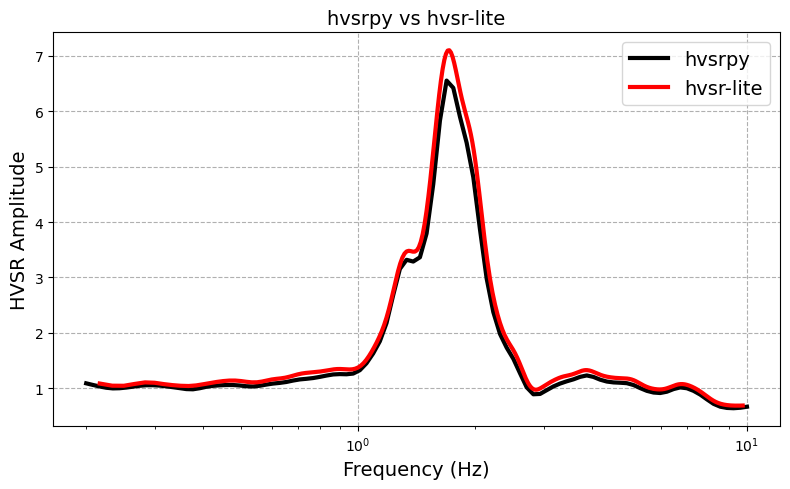

In [10]:
# Comparison plot
if files_exist and hvsrpy_result is not None:
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    colors = {
        "hvsrpy": "black",
        "hvsr_lite": "red",
    }

    ax.semilogx(
        hvsrpy_result["frequencies"],
        hvsrpy_result["hvsr_values"],
        color=colors["hvsrpy"],
        linewidth=3,
        label="hvsrpy",
    )

    if "hvsr_lite_result" in globals() and hvsr_lite_result is not None:
        ax.semilogx(
            hvsr_lite_result.frequencies,
            hvsr_lite_result.hvsr_values,
            color=colors["hvsr_lite"],
            linewidth=3,
            label="hvsr-lite",
        )

    ax.set_xlabel("Frequency (Hz)", fontsize=14)
    ax.set_ylabel("HVSR Amplitude", fontsize=14)
    ax.set_title("hvsrpy vs hvsr-lite", fontsize=14)
    ax.grid(True, linestyle="--")
    ax.legend(fontsize=14)

    plt.tight_layout()
    plt.show()
